In [11]:
!pip install tqdm

In [1]:
import cv2 as cv
import numpy as np
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

In [2]:
base_dir = "/kaggle/input/mini-face-forensics/FF++/"

In [3]:
# Example data
video_paths = []
labels = []  


for sub_folder in os.listdir(base_dir):
    label = 1 if sub_folder == 'real' else 0
    
    sub_folder = os.path.join(base_dir, sub_folder)
    
    for vid in os.listdir(sub_folder):
        video_paths.append(os.path.join(sub_folder, vid))
        labels.append(label)

In [4]:
# Print the first 10 and last 10 elements of video_paths
print("First 10 video paths:", video_paths[:10])
print("Last 10 video paths:", video_paths[-10:])

# Print the first 10 and last 10 elements of labels
print("First 10 labels:", labels[:10])
print("Last 10 labels:", labels[-10:])


First 10 video paths: ['/kaggle/input/mini-face-forensics/FF++/fake/02_13__exit_phone_room__CP5HFV3K.mp4', '/kaggle/input/mini-face-forensics/FF++/fake/03_14__talking_against_wall__ZC2KYASW.mp4', '/kaggle/input/mini-face-forensics/FF++/fake/03_15__outside_talking_pan_laughing__Y11NT1YX.mp4', '/kaggle/input/mini-face-forensics/FF++/fake/07_26__walking_down_street_outside_angry__FGNGC2GT.mp4', '/kaggle/input/mini-face-forensics/FF++/fake/07_03__hugging_happy__7NGMD8FT.mp4', '/kaggle/input/mini-face-forensics/FF++/fake/07_09__walk_down_hall_angry__N9CWME71.mp4', '/kaggle/input/mini-face-forensics/FF++/fake/01_12__outside_talking_pan_laughing__TNI7KUZ6.mp4', '/kaggle/input/mini-face-forensics/FF++/fake/07_03__podium_speech_happy__6PHZRQ4H.mp4', '/kaggle/input/mini-face-forensics/FF++/fake/07_02__walking_down_street_outside_angry__O4SXNLRL.mp4', '/kaggle/input/mini-face-forensics/FF++/fake/08_05__walk_down_hall_angry__FBICSP2C.mp4']
Last 10 video paths: ['/kaggle/input/mini-face-forensics/F

## Extract frames from videos

In [5]:
# !pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.0 MB/s eta 0:00:0000:010:01m


In [6]:
from mtcnn import MTCNN

detector = MTCNN()

In [7]:
# enhancing the image
def unsharp_mask(image, sigma=1.0, strength=1.5):
    blurred = cv.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv.addWeighted(image, 1 + strength, blurred, -strength, 0)
    return sharpened

def enhance_frame_with_unsharp_mask(frame):
    return unsharp_mask(frame)

In [9]:

def extract_frames(video_path, max_frames=20, target_size=(224, 224)):
    cap = cv.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        # Detect faces
        detections = detector.detect_faces(frame)
        
        if detections:
            # Get the bounding box of the first detected face
            x, y, width, height = detections[0]['box']
            face_region = frame[y:y+height, x:x+width]

            # Enhance the face region (optional)
            enhanced_face = unsharp_mask(face_region)

            # Resize the enhanced face to target size
            resized_face = cv.resize(enhanced_face, target_size)

            # Append the resized face to the frames list
            frames.append(resized_face / 255.0)  # Normalize to [0, 1] range
            frame_count += 1  # Increment frame count only if a face was detected

    cap.release()
    return np.array(frames)



In [10]:
demo_frames = extract_frames('/kaggle/input/mini-face-forensics/FF++/fake/01_11__meeting_serious__9OM3VE0Y.mp4')


array([[[0.30588235, 0.29803922, 0.30588235],
        [0.31764706, 0.30980392, 0.31764706],
        [0.34901961, 0.34117647, 0.34901961],
        ...,
        [0.16078431, 0.12156863, 0.11372549],
        [0.15294118, 0.11372549, 0.10588235],
        [0.14901961, 0.10980392, 0.10196078]],

       [[0.30588235, 0.29803922, 0.30588235],
        [0.31372549, 0.30588235, 0.31372549],
        [0.33333333, 0.32156863, 0.33333333],
        ...,
        [0.16078431, 0.12156863, 0.11372549],
        [0.14901961, 0.10980392, 0.10588235],
        [0.14509804, 0.10588235, 0.09803922]],

       [[0.30980392, 0.29803922, 0.30588235],
        [0.30980392, 0.29803922, 0.30588235],
        [0.30980392, 0.29803922, 0.30588235],
        ...,
        [0.16078431, 0.12156863, 0.11764706],
        [0.14509804, 0.10980392, 0.10588235],
        [0.1372549 , 0.10196078, 0.09803922]],

       ...,

       [[0.25098039, 0.22745098, 0.20392157],
        [0.25098039, 0.22352941, 0.2       ],
        [0.25490196, 0

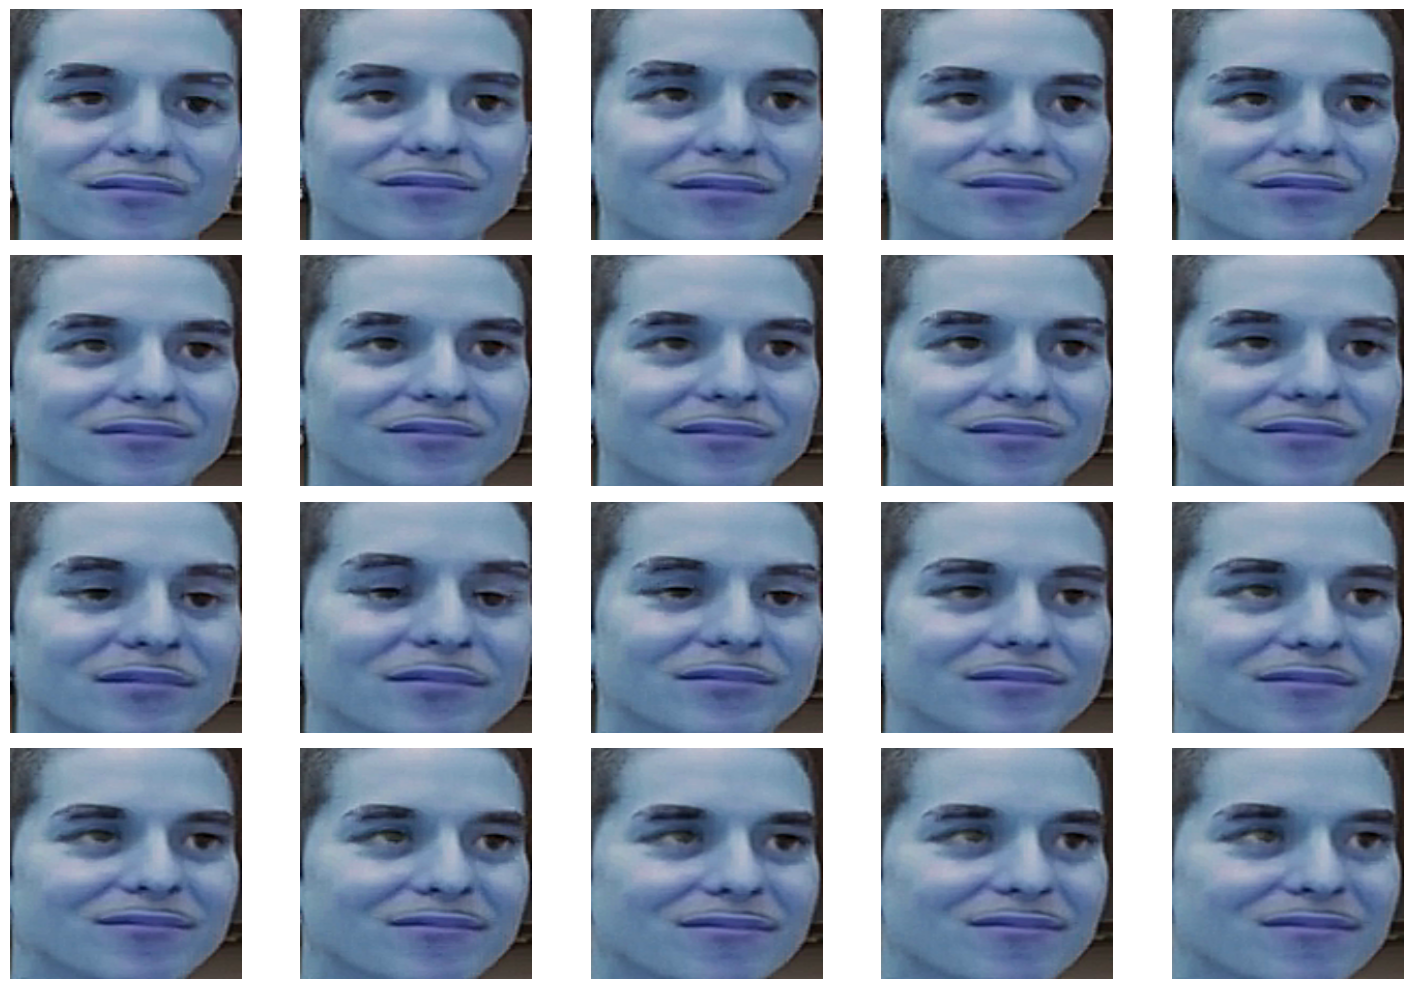

In [13]:
import matplotlib.pyplot as plt

num_frames = len(demo_frames)
cols = 5
rows = (num_frames + cols - 1) // cols  # Calculate the number of rows needed


fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

for i in range(num_frames):
    # Convert the normalized frame to 0-255 range for display
    frame = (demo_frames[i] * 255).astype(np.uint8)
    
    # Plot the frame in its subplot
    ax = axes[i // cols, i % cols]
    ax.imshow(frame)
    ax.axis('off')

# Hide any remaining empty subplots
for j in range(num_frames, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()
plt.show()


## Feature Extraction Using Pretrained CNN (VGG16)

In [20]:
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

def extract_features(frames):
    frame_features = []
    for frame in frames:
        frame = np.expand_dims(frame, axis=0)  # add batch dimension
        feature = vgg_model.predict(frame)
        frame_features.append(feature)
    return np.array(frame_features).reshape(len(frames), -1)  # flatten features

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Prepare the dataset

In [21]:
def prepare_data(video_paths, labels, max_frames=20):
    X, y = [], []
    for video_path, label in zip(video_paths, labels):
        frames = extract_frames(video_path, max_frames=max_frames)
        features = extract_features(frames)
        X.append(features)
        y.append(label)
    return np.array(X), np.array(y)


## LSTM Model

In [22]:
def build_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(LSTM(256))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Example: Input shape is (sequence_length, feature_vector_size)
sequence_length = 20
feature_vector_size = 7 * 7 * 512  # Flattened feature vector size from VGG16
num_classes = 10  # Number of classes in your dataset

model = build_lstm_model((sequence_length, feature_vector_size), num_classes)
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 256)        │    25,953,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,512,778 (101.14 MB)

 Trainable params: 26,512,778 (101.14 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [26]:
# Prepare the data
X_train, y_train = prepare_data(video_paths, labels)

# Train the LSTM model
model.fit(X_train, y_train, batch_size=8, epochs=10, validation_split=0.2)


I0000 00:00:1730146802.670806     749 service.cc:145] XLA service 0x7ec6e8001f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730146802.670861     749 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730146802.670865     749 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


I0000 00:00:1730146804.998371     749 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 